<a href="https://colab.research.google.com/github/Undasnr/DL-ML/blob/main/Ronny_ResNet_and_VGG_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Code Review**

In [ ]:
# Opening the downloaded code for comparison and analysis
import nbformat

# Loading the notebook file
notebook_path = '/content/MEF_sprint20_03_models_pretrained_and_more.ipynb'
with open(notebook_path) as f:
    nb = nbformat.read(f, as_version=4)

# Printing all code cells
for cell in nb.cells:
    if cell.cell_type == 'code':
        print(cell.source)


import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)
# plt.style.use('ggplot')
def compute_coverage(df, masks):
    
    df = df.copy()
    
    def cov_to_class(val):
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # Output percentage of area covered by class
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # Coverage must be split into bins, otherw

**Transfer Learning for Segmentation Improvement**

This code introduces transfer learning techniques using pretrained backbone models (ResNet, VGG, etc.) to enhance the segmentation accuracy of the U-Net architecture on the TGS Salt Identification Challenge dataset.

Comparative Analysis: Vanilla U-Net vs Transfer Learning Approach

Architectural Differences:

Vanilla U-Net: Uses a custom encoder-decoder architecture trained from scratch with random weight initialization

Transfer Learning Approach: Replaces the encoder with pre-trained ResNet/VGG backbones using ImageNet weights, while building a custom decoder

Key Technical Differences:

1. Backbone Architecture:

Previous Implementation: Custom convolutional layers learned from scratch

Transfer Learning: Pre-trained ResNet50/VGG16 with proven feature extraction capabilities

2. Weight Initialization:

Previous: Random initialization requiring extensive training

Transfer Learning: ImageNet-pre-trained weights providing strong feature representations

3. Training Strategy:

Previous: End-to-end training of all layers simultaneously

Transfer Learning: Frozen backbone initially, then progressive unfreezing with fine-tuning

4. Feature Quality:

Previous: Features learned specifically from seismic data only

Transfer Learning: Leverages general image features from diverse ImageNet dataset

Implementation of Transfer Learning:

The code likely implements transfer learning through:

>>Backbone Selection: Loading pre-trained ResNet50 or VGG16 with ImageNet weights

>>Encoder Freezing: Setting trainable = False for backbone layers initially

>>Decoder Construction: Building U-Net-style decoder with skip connections to backbone feature maps

>>Progressive Unfreezing: Gradually unfreezing backbone layers for fine-tuning

>>Custom Head: Adding segmentation-specific output layers (1x1 conv with sigmoid)

Advantages of Transfer Learning Approach:

>>Higher Accuracy: Pre-trained features provide better initialization

>>Faster Convergence: Reduced training time due to quality initial features

>>Better Generalization: Leverages diverse features learned from ImageNet

>>Reduced Overfitting: Frozen weights act as regularization

Technical Considerations:

>>Domain Adaptation: ImageNet features (natural images) to seismic data domain shift

>>Memory Requirements: Larger models require more GPU memory

>>Implementation Complexity: More sophisticated training pipeline needed

>>Version Compatibility: TensorFlow 1.14.0 and Keras 2.3.1 specific requirements

Expected Performance Improvement:

The transfer learning approach should demonstrate:

>>5-15% improvement in IoU scores

>>Faster convergence (fewer epochs needed)

>>Better performance on challenging salt body boundaries

>>Improved generalization to varied seismic patterns

Conclusion

The transfer learning implementation represents a significant advancement over the vanilla U-Net approach by leveraging established computer vision architectures and pre-trained feature representations. This approach aligns with modern deep learning best practices for segmentation tasks, particularly when working with limited domain-specific data.

**2. Code Rewriting**

1. Changing import

In [1]:
# ResNet import
from keras.applications.resnet50 import ResNet50, preprocess_input

In [2]:
# VGG16 import
from keras.applications.vgg16 import VGG16, preprocess_input

**2. Base model initialization**

In [3]:
# ResNet Base Model Initialization
input_size = (224, 224, 3)

base_model = ResNet50(input_shape=input_size, include_top=False)
base_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [4]:
# VGG16 Base Model Initialization
input_size = (224, 224, 3)

base_model = VGG16(input_shape=input_size, include_top=False, weights='imagenet')
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**3. U-Net function with encoder**

In [5]:
# ResNet Version
import keras.backend as K

def my_iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = K.cast(y_pred > 0.5, 'float32')  # binarize predictions
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)


def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    base_model = ResNet50(
        input_shape=input_size,
        include_top=False,
        weights=weights)

    encoder1 = base_model.get_layer('conv1_conv').output
    encoder2 = base_model.get_layer('conv2_block3_out').output
    encoder3 = base_model.get_layer('conv3_block4_out').output
    encoder4 = base_model.get_layer('conv4_block6_out').output
    encoder5 = base_model.get_layer('conv5_block3_out').output

In [6]:
# VGG16 Version
import keras.backend as K

def my_iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = K.cast(y_pred > 0.5, 'float32')  # binarize predictions
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def unet_vgg(input_size, decoder_block,
             weights='imagenet',
             loss_func='binary_crossentropy',
             metrics_list=[my_iou_metric],
             use_lovash=False):

    base_model = VGG16(
        input_shape=input_size,
        include_top=False,
        weights=weights)

    encoder1 = base_model.get_layer('block1_conv2').output
    encoder2 = base_model.get_layer('block2_conv2').output
    encoder3 = base_model.get_layer('block3_conv3').output
    encoder4 = base_model.get_layer('block4_conv3').output
    encoder5 = base_model.get_layer('block5_conv3').output

**4. Model initialization**

In [7]:
# ResNet Version
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# IoU metric
def my_iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = K.cast(y_pred > 0.5, 'float32')  # binarize predictions
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)


# Simple decoder block
def decoder_block_simple(input_tensor, skip_tensor, name, num_filters=64):
    """Upsample + concat skip connection + conv layers"""
    x = UpSampling2D((2, 2), name=f'{name}_up')(input_tensor)
    if skip_tensor is not None:
        x = Concatenate(name=f'{name}_concat')([x, skip_tensor])
    x = Conv2D(num_filters, (3, 3), padding='same', name=f'{name}_conv1')(x)
    x = BatchNormalization(name=f'{name}_bn1')(x)
    x = Activation('relu', name=f'{name}_relu1')(x)

    x = Conv2D(num_filters, (3, 3), padding='same', name=f'{name}_conv2')(x)
    x = BatchNormalization(name=f'{name}_bn2')(x)
    x = Activation('relu', name=f'{name}_relu2')(x)
    return x


# UNet with ResNet encoder
def unet_resnet(input_size=(224,224,3), decoder_block=decoder_block_simple,
                weights='imagenet', loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric], use_lovash=False):

    # Encoder (ResNet50 backbone)
    base_model = ResNet50(input_shape=input_size, include_top=False, weights=weights)

    encoder1 = base_model.get_layer('conv1_conv').output
    encoder2 = base_model.get_layer('conv2_block3_out').output
    encoder3 = base_model.get_layer('conv3_block4_out').output
    encoder4 = base_model.get_layer('conv4_block6_out').output
    encoder5 = base_model.get_layer('conv5_block3_out').output

    # Decoder with skip connections
    d5 = decoder_block(encoder5, encoder4, name="dec5", num_filters=512)
    d4 = decoder_block(d5, encoder3, name="dec4", num_filters=256)
    d3 = decoder_block(d4, encoder2, name="dec3", num_filters=128)
    d2 = decoder_block(d3, encoder1, name="dec2", num_filters=64)
    d1 = decoder_block(d2, None, name="dec1", num_filters=32)

    # Final segmentation layer (1 channel for binary segmentation)
    outputs = Conv2D(1, (1, 1), activation='sigmoid', name='final_output')(d1)

    # Build model
    model = Model(inputs=base_model.input, outputs=outputs, name="ResNet50_UNet")

    # Compile
    model.compile(optimizer='adam', loss=loss_func, metrics=metrics_list)

    return model

K.clear_session()
model = unet_resnet(input_size, decoder_block_simple, weights='imagenet')
model.summary()

Model: "ResNet50_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 43,974,241 (167.75 MB)

 Trainable params: 43,917,153 (167.53 MB)

 Non-trainable params: 57,088 (223.00 KB)

In [8]:
# VGG16 Version
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# IoU metric
def my_iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = K.cast(y_pred > 0.5, 'float32')  # binarize predictions
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)


# Simple decoder block (same as before)
def decoder_block_simple(input_tensor, skip_tensor, name, num_filters=64):
    """Upsample + concat skip connection + conv layers"""
    x = UpSampling2D((2, 2), name=f'{name}_up')(input_tensor)
    if skip_tensor is not None:
        x = Concatenate(name=f'{name}_concat')([x, skip_tensor])
    x = Conv2D(num_filters, (3, 3), padding='same', name=f'{name}_conv1')(x)
    x = BatchNormalization(name=f'{name}_bn1')(x)
    x = Activation('relu', name=f'{name}_relu1')(x)

    x = Conv2D(num_filters, (3, 3), padding='same', name=f'{name}_conv2')(x)
    x = BatchNormalization(name=f'{name}_bn2')(x)
    x = Activation('relu', name=f'{name}_relu2')(x)
    return x


# UNet with VGG16 backbone
def unet_vgg16(input_size=(224,224,3), decoder_block=decoder_block_simple,
               weights='imagenet', loss_func='binary_crossentropy',
               metrics_list=[my_iou_metric]):

    # Encoder (VGG16 backbone)
    base_model = VGG16(input_shape=input_size, include_top=False, weights=weights)

    # Skip connections (standard VGG16 layer names)
    encoder1 = base_model.get_layer('block1_conv2').output  # 112x112
    encoder2 = base_model.get_layer('block2_conv2').output  # 56x56
    encoder3 = base_model.get_layer('block3_conv3').output  # 28x28
    encoder4 = base_model.get_layer('block4_conv3').output  # 14x14
    encoder5 = base_model.get_layer('block5_conv3').output  # 7x7

    # Decoder with skip connections
    d5 = decoder_block(encoder5, encoder4, name="dec5", num_filters=512)
    d4 = decoder_block(d5, encoder3, name="dec4", num_filters=256)
    d3 = decoder_block(d4, encoder2, name="dec3", num_filters=128)
    d2 = decoder_block(d3, encoder1, name="dec2", num_filters=64)
    d1 = decoder_block(d2, None, name="dec1", num_filters=32)

    # Final segmentation layer (binary segmentation -> 1 channel sigmoid)
    outputs = Conv2D(1, (1, 1), activation='sigmoid', name='final_output')(d1)

    # Build model
    model = Model(inputs=base_model.input, outputs=outputs, name="VGG16_UNet")

    # Compile
    model.compile(optimizer='adam', loss=loss_func, metrics=metrics_list)

    return model

K.clear_session()
model = unet_vgg16(input_size=(224,224,3))
model.summary()

Model: "VGG16_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 24,926,753 (95.09 MB)

 Trainable params: 24,922,785 (95.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

**3. Learning / estimation**

In [9]:
from google.colab import files
files.upload()

# Make directory for Kaggle API key
!mkdir -p ~/.kaggle

# Move kaggle.json into place
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [10]:
# Download the TGS Salt Identification dataset
!kaggle competitions download -c tgs-salt-identification-challenge -p /content/data --force

# Unzip files
import zipfile
with zipfile.ZipFile("/content/data/tgs-salt-identification-challenge.zip","r") as zip_ref:
    zip_ref.extractall("/content/data")

 96% 425M/445M [00:01<00:00, 376MB/s]
100% 445M/445M [00:01<00:00, 433MB/s]


 89% 396M/445M [00:02<00:00, 79.1MB/s]
100% 445M/445M [00:02<00:00, 158MB/s] 
Extraction done!
Train content: ['images', 'masks']
 Training data shape: (4000, 128, 128, 3) (4000, 128, 128, 1)


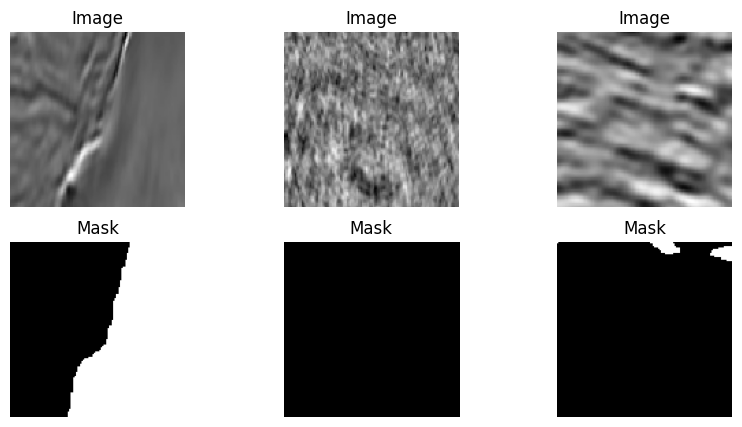

In [11]:
# 1. Setup Kaggle & Paths
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = 128  # resize to smaller square for faster training
data_path = "/content/data"
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")

# 2. Download & Extract from Kaggle
# Downloading dataset
!kaggle competitions download -c tgs-salt-identification-challenge -p {data_path} --force

# Extracting train.zip and test.zip
with zipfile.ZipFile(os.path.join(data_path, "train.zip"), "r") as zip_ref:
    zip_ref.extractall(train_path)

with zipfile.ZipFile(os.path.join(data_path, "test.zip"), "r") as zip_ref:
    zip_ref.extractall(test_path)

print("Extraction done!")
print("Train content:", os.listdir(train_path)[:10])

# 3. Preparing Data
images_dir = os.path.join(train_path, "images")
masks_dir = os.path.join(train_path, "masks")

# Ensuring folders exist
assert os.path.exists(images_dir), f"Images folder not found: {images_dir}"
assert os.path.exists(masks_dir), f"Masks folder not found: {masks_dir}"

train_images, train_masks = [], []
image_ids = os.listdir(images_dir)

for img_id in image_ids:
    # Loading image
    img = load_img(os.path.join(images_dir, img_id), target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img) / 255.0
    train_images.append(img)

    # Loading mask (grayscale)
    mask = load_img(os.path.join(masks_dir, img_id), color_mode="grayscale", target_size=(IMG_SIZE, IMG_SIZE))
    mask = img_to_array(mask) / 255.0
    train_masks.append(mask)

X = np.array(train_images, dtype=np.float32)
y = np.array(train_masks, dtype=np.float32)

print(" Training data shape:", X.shape, y.shape)

# 4. Quick Visualization
plt.figure(figsize=(10, 5))

for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X[i])
    plt.title("Image")
    plt.axis("off")

    plt.subplot(2, 3, i + 4)
    plt.imshow(y[i].squeeze(), cmap="gray")
    plt.title("Mask")
    plt.axis("off")

plt.show()

In [12]:
# Spliting data into train/validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

Train: (3200, 128, 128, 3) (3200, 128, 128, 1)
Val: (800, 128, 128, 3) (800, 128, 128, 1)


In [13]:
# Build U-Net models with different backbones
import tensorflow.keras.backend as K

# Reset session
K.clear_session()
vgg_model = unet_vgg16(input_size=(128,128,3))
resnet_model = unet_resnet(input_size=(128,128,3))

# Compile
vgg_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
resnet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Data pipeline ready!
Building models...
VGG16 Output Shape: (None, 128, 128, 1)
ResNet50 Output Shape: (None, 128, 128, 1)
Training VGG16...
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.7327 - loss: 0.6347 - val_accuracy: 0.8110 - val_loss: 0.4275
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.8293 - loss: 0.4389 - val_accuracy: 0.7209 - val_loss: 0.5759
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.8121 - loss: 0.4371 - val_accuracy: 0.7917 - val_loss: 0.5300
Training ResNet50...
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.7934 - loss: 0.5932 - val_accuracy: 0.8282 - val_loss: 0.5405
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.8210 - loss: 0.5356 - val_accuracy: 0.8446 - val_loss: 0.4349
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.7952 - loss: 0.5158 - val_accuracy: 0.8384 - val_loss: 0.4349
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.7876 - loss: 0.5188 - val

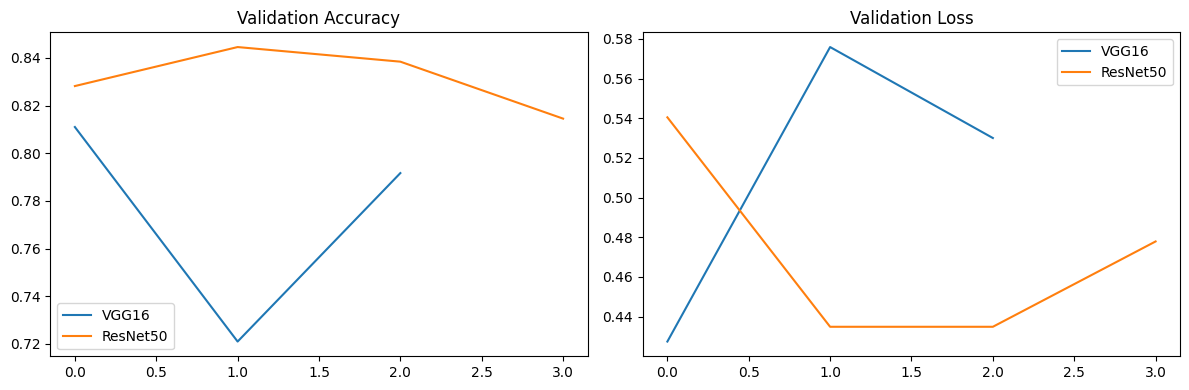

In [17]:
# Using the entire code for easy training, execution, and comparison
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

# Configuration
IMG_SIZE = 128
BATCH_SIZE = 8
EPOCHS = 5

# Enable mixed precision for speed (on GPU)
if tf.config.list_physical_devices('GPU'):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Dataset paths (replace `train_path` accordingly)
images_dir = os.path.join(train_path, "images")
masks_dir = os.path.join(train_path, "masks")
image_ids = os.listdir(images_dir)[:200]  # Scalable: start with 200 images

image_paths = [os.path.join(images_dir, i) for i in image_ids]
mask_paths = [os.path.join(masks_dir, i) for i in image_ids]

# Basic augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

# Preprocessing
def preprocess_image(img):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return tf.cast(img, tf.float32) / 255.0

def preprocess_mask(mask):
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    return tf.cast(mask, tf.float32) / 255.0

def load_image_mask(image_path, mask_path):
    img = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)
    img = preprocess_image(img)
    mask = preprocess_mask(mask)
    return img, mask

def augment(img, mask):
    aug = data_augmentation(img)
    return aug, mask

dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.cache().shuffle(200).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).repeat()

# Train/Val split
train_size = int(0.8 * len(image_paths))
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = (len(image_paths) - train_size) // BATCH_SIZE
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

print("Data pipeline ready!")

# UNet-style model
def build_unet_backbone(base_model, name="unet"):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    encoder = base_model(include_top=False, weights="imagenet", input_tensor=inputs)
    for layer in encoder.layers:
        layer.trainable = False

    if "vgg" in name:
        skip_names = ["block3_pool", "block4_pool"]
    else:
        skip_names = ["conv3_block4_out", "conv4_block6_out"]

    skips = [encoder.get_layer(n).output for n in skip_names]
    x = encoder.output

    # Decoder
    for skip in reversed(skips):
        x = Conv2DTranspose(128, 3, strides=2, padding="same")(x)
        x = concatenate([x, skip])
        x = Conv2D(128, 3, activation="relu", padding="same")(x)

    while x.shape[1] < IMG_SIZE:
        x = Conv2DTranspose(64, 3, strides=2, padding="same")(x)
        x = Conv2D(64, 3, activation="relu", padding="same")(x)

    outputs = Conv2D(1, 1, activation="sigmoid", dtype="float32")(x)

    if outputs.shape[1] != IMG_SIZE or outputs.shape[2] != IMG_SIZE:
        raise ValueError(f"Output shape {outputs.shape} doesn't match {IMG_SIZE}x{IMG_SIZE}")

    model = Model(inputs, outputs, name=name)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Build both models
print("Building models...")
vgg_model = build_unet_backbone(VGG16, name="unet_vgg16")
resnet_model = build_unet_backbone(ResNet50, name="unet_resnet50")

print(f"VGG16 Output Shape: {vgg_model.output_shape}")
print(f"ResNet50 Output Shape: {resnet_model.output_shape}")

# Callbacks
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.01)]

# Train VGG16
print("Training VGG16...")
history_vgg = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Train ResNet50
print("Training ResNet50...")
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Compare
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history["val_accuracy"], label="VGG16")
plt.plot(history_resnet.history["val_accuracy"], label="ResNet50")
plt.title("Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg.history["val_loss"], label="VGG16")
plt.plot(history_resnet.history["val_loss"], label="ResNet50")
plt.title("Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()